In [3]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

### Load and Preprocess the Dataset

In [12]:
train_df = pd.read_csv('train.csv')

numeric_columns = train_df.select_dtypes(include=['float64', 'int64']).columns
train_df[numeric_columns] = train_df[numeric_columns].fillna(train_df[numeric_columns].mean())

categorical_columns = train_df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    train_df[col].fillna(train_df[col].mode()[0], inplace=True)

train_df.drop_duplicates(inplace=True)

label_encoder = LabelEncoder()
train_df['species'] = label_encoder.fit_transform(train_df['species'])
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

print("\nLabel Mapping:", label_mapping)

def load_images(image_folder, image_names, target_size=(128, 128)):
    images = []
    for name in image_names:
        img_path = os.path.join(image_folder, name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return np.array(images)

image_folder = 'images'
train_images = load_images(image_folder, train_df['id'].astype(str) + '.jpg')
train_images = train_images / 255.0

train_df.drop('id', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    train_images, train_df['species'].values, test_size=0.2, stratify=train_df['species'].values, random_state=42
)

num_classes = len(np.unique(y_train))

C:\Users\tayseer\AppData\Local\Temp\ipykernel_14544\3001201815.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].mode()[0], inplace=True)



Label Mapping: {np.int64(0): 'Acer_Capillipes', np.int64(1): 'Acer_Circinatum', np.int64(2): 'Acer_Mono', np.int64(3): 'Acer_Opalus', np.int64(4): 'Acer_Palmatum', np.int64(5): 'Acer_Pictum', np.int64(6): 'Acer_Platanoids', np.int64(7): 'Acer_Rubrum', np.int64(8): 'Acer_Rufinerve', np.int64(9): 'Acer_Saccharinum', np.int64(10): 'Alnus_Cordata', np.int64(11): 'Alnus_Maximowiczii', np.int64(12): 'Alnus_Rubra', np.int64(13): 'Alnus_Sieboldiana', np.int64(14): 'Alnus_Viridis', np.int64(15): 'Arundinaria_Simonii', np.int64(16): 'Betula_Austrosinensis', np.int64(17): 'Betula_Pendula', np.int64(18): 'Callicarpa_Bodinieri', np.int64(19): 'Castanea_Sativa', np.int64(20): 'Celtis_Koraiensis', np.int64(21): 'Cercis_Siliquastrum', np.int64(22): 'Cornus_Chinensis', np.int64(23): 'Cornus_Controversa', np.int64(24): 'Cornus_Macrophylla', np.int64(25): 'Cotinus_Coggygria', np.int64(26): 'Crataegus_Monogyna', np.int64(27): 'Cytisus_Battandieri', np.int64(28): 'Eucalyptus_Glaucescens', np.int64(29): 'E

### Display Sample Images

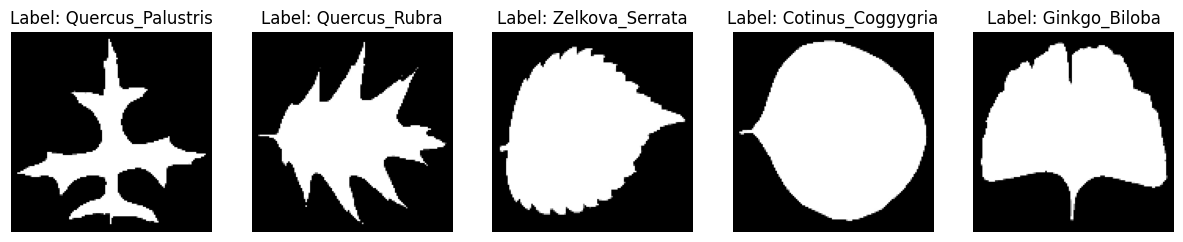

In [15]:
num_samples = 5
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {label_mapping[y_train[i]]}")
    plt.axis('off')
plt.show()

### Building and Training Neural Network

In [16]:
batch_size = 32
num_layers = 2
dropout_rate = 0.5
optimizer_name = 'adam'
weight_decay = 0.01
initial_lr = 0.001
lr_scheduler = None
epochs = 20


model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3),
                 kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

for _ in range(num_layers - 1):
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Dropout(dropout_rate))
model.add(Dense(y_train.max() + 1, activation='softmax', kernel_regularizer=l2(weight_decay)))

if optimizer_name == 'adam':
    optimizer = Adam(learning_rate=initial_lr)
elif optimizer_name == 'sgd':
    optimizer = SGD(learning_rate=initial_lr, momentum=0.9)
elif optimizer_name == 'rmsprop':
    optimizer = RMSprop(learning_rate=initial_lr)
else:
    raise ValueError("Invalid optimizer. Choose 'adam', 'sgd', or 'rmsprop'.")

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = []
if lr_scheduler:
    callbacks.append(LearningRateScheduler(lr_scheduler))

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

model.save('leaf_classification_cnn_model.keras')
print("\nModel saved as 'leaf_classification_cnn_model.keras'")

c:\Users\tayseer\Desktop\Deep-Learning\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 437ms/step - accuracy: 0.0182 - loss: 8.0498 - val_accuracy: 0.0253 - val_loss: 6.2825
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 414ms/step - accuracy: 0.0304 - loss: 6.0278 - val_accuracy: 0.0808 - val_loss: 5.4787
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 519ms/step - accuracy: 0.0724 - loss: 5.2929 - val_accuracy: 0.2071 - val_loss: 4.9161
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 449ms/step - accuracy: 0.1731 - loss: 4.7828 - val_accuracy: 0.3788 - val_loss: 4.4756
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 523ms/step - accuracy: 0.3132 - loss: 4.1319 - val_accuracy: 0.4444 - val_loss: 3.8524
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 505ms/step - accuracy: 0.4196 - loss: 3.7023 - val_accuracy: 0.4646 - val_loss: 3.7840
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.4446 - loss: 3.5352 - val_accuracy: 0.4495 - val_loss: 3.5408
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 387ms/step - accuracy: 0.5001 - loss: 3.1852 - val_accu

### Evaluation

In [17]:
model_path = 'leaf_classification_cnn_model.keras'

model = tf.keras.models.load_model(model_path)
print(f"\nModel loaded from {model_path}")

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\nEvaluating on Training Set:")
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

print("\nEvaluating on Test Set:")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_classes))


Model loaded from leaf_classification_cnn_model.keras

Evaluating on Training Set:
Training Accuracy: 97.35%

Evaluating on Test Set:
Test Accuracy: 54.04%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       1.00      0.50      0.67         2
           2       0.40      1.00      0.57         2
           3       1.00      0.50      0.67         2
           4       0.67      1.00      0.80         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.67      1.00      0.80         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      0.50      0.67         2
          11       0.00      0.00      0.00         2
          12       0.50      0.50      0.50         2
          13 

c:\Users\tayseer\Desktop\Deep-Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tayseer\Desktop\Deep-Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tayseer\Desktop\Deep-Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

### Plotting Training History

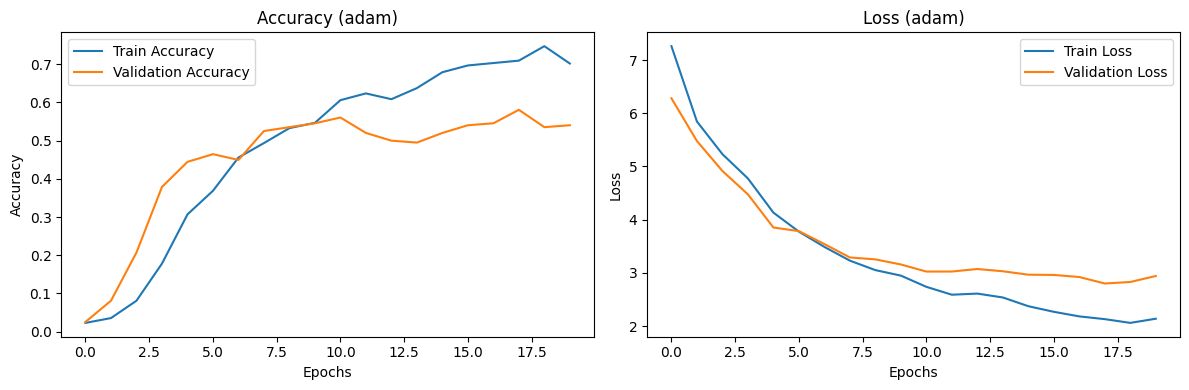

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracy ({optimizer_name})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Loss ({optimizer_name})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Classify new images

In [19]:
model = tf.keras.models.load_model(model_path)
print(f"\nModel loaded from {model_path}")

def preprocess_image(img_path, target_size=(128, 128)):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, target_size)
        img = img / 255.0 
        return img
    return None

images = []
valid_image_names = []

test_images_folder = 'test_images'
test_images = ['1.jpg', '2.jpg', '3.jpg','40.jpg']
for name in test_images:
    img_path = os.path.join(test_images_folder, name)
    img = preprocess_image(img_path)
    if img is not None:
        images.append(img)
        valid_image_names.append(name)
    else:
        print(f"Warning: Could not load image {name}. Skipping.")

if not images:
    print("No valid images to classify.")
else:
    images = np.array(images)
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    for i, name in enumerate(valid_image_names):
        print(f"Image: {name} -> Predicted Label: {label_mapping[predicted_classes[i]]}")


Model loaded from leaf_classification_cnn_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Image: 1.jpg -> Predicted Label: Acer_Opalus
Image: 2.jpg -> Predicted Label: Pterocarya_Stenoptera
Image: 3.jpg -> Predicted Label: Quercus_Hartwissiana
Image: 40.jpg -> Predicted Label: Quercus_Phillyraeoides
